In [3]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
import time

#basic externals
import pandas as pd
import numpy as np
import os
import matplotlib as plt

%matplotlib inline
%reload_ext autoreload
%autoreload 2


InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

In [4]:
from xm_functions import *

In [5]:
import sys
print(sys.executable)

C:\Users\Maly-Fenix\Anaconda3\envs\prophet\python.exe


In [6]:
import feather
df_train = feather.read_dataframe('df_train').drop('index', axis = 1)

In [7]:
df=df_train.copy()

In [8]:
df = df.query('Open==1 & Sales >0').reset_index(drop=True)

In [11]:

max_date=df['Date'].max()
from datetime import datetime, timedelta
train_size=48
test_date = max_date-timedelta(days=train_size)
nb_rows= len(df); 
print(nb_rows,'rows before split')

data_train = df.query('Date < @test_date')
data_test = df.query('Date >= @test_date')


844338 rows before split


In [12]:
data_train.shape
data_test.shape

(797340, 40)

(46998, 40)

In [13]:
y_col = 'Sales'

y=df[y_col].values
X=df.drop(y_col, axis = 1).values
######################
y_train = data_train[y_col]
X_train = data_train.drop(y_col, axis = 1)
######################
y_test = data_test[y_col]
y_true=y_test
X_test = data_test.drop(y_col, axis = 1)

In [14]:
cols= ['Date', 'Store', 'Sales']
df_train = data_train[cols].reset_index(drop=True)
df_test = data_test[cols].reset_index(drop=True)
df_train.columns = ['ds','Store', 'y']
df_test.columns = ['ds','Store', 'y']

In [15]:
from fbprophet import Prophet

In [16]:
df_results = pd.DataFrame(columns=['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'Store'])
df_results_train = pd.DataFrame(columns=['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y', 'Store'])

for store_i in np.sort(df_train['Store'].unique()):
    if store_i%10 ==0:
        print(store_i, end='')
    else: 
        print('.', end= '')
        
    df_train_i= df_train.query('Store == @store_i').reset_index()
    m = Prophet(daily_seasonality=False)

    fit = m.fit(df_train_i[ ['ds', 'y']])
    
    df_test_i= df_test.query('Store == @store_i').reset_index()

    forecast = m.predict(df_train_i[['ds']]).join(df_train_i[['y', 'Store']])
    df_results_train = pd.concat([df_results_train, forecast[df_results_train.columns]])
    
    forecast = m.predict(df_test_i[['ds']]).join(df_test_i[['y', 'Store']])
    df_results = pd.concat([df_results, forecast[df_results.columns]])


.

C:\Users\Maly-Fenix\Anaconda3\envs\prophet\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


........10.........20.........30.........40.........50.........60.........70.........80.........90.........100..

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


.......110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630.........640.........650.........660.........670.........680.........690.........700.........710.........720.........730.........740.........750.........760.........770.........780.........790.........800.........810.........820.........830.........840.........850.........860.........870.........880.........890.........900.........910.........920.........930......

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


.........1090.........1100.........1110.....

In [17]:
df_results_full = pd.concat([df_results_train, df_results])

In [18]:
df_results_full.reset_index().to_feather('prophet_predictions')

### Last store plots

Showing last Store plots


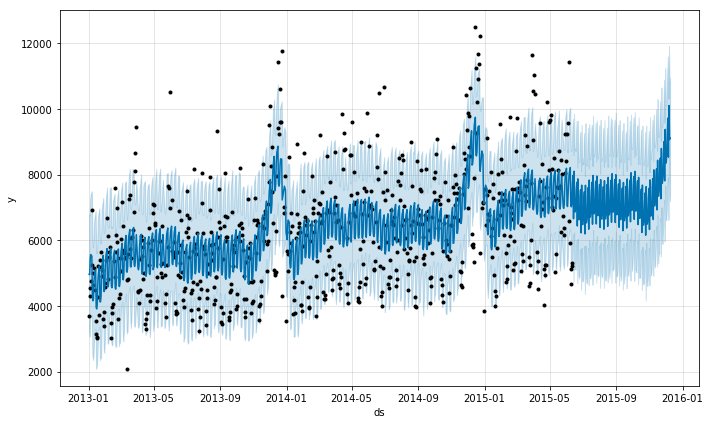

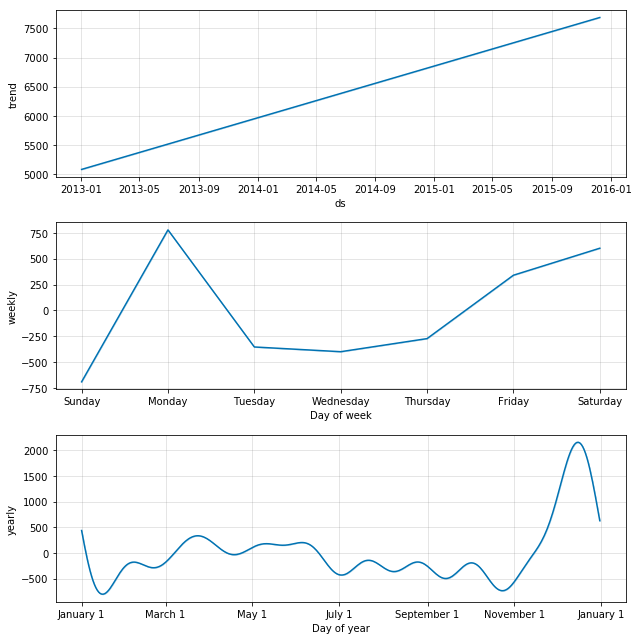

In [19]:
fig_size(8,4,10)

m = Prophet(daily_seasonality=False)
fit = m.fit(df_train_i[ ['ds', 'y']])
future = m.make_future_dataframe(periods=180)
forecast = m.predict(future)

print('Showing last Store plots')
fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

In [20]:

def rmspe_calc(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))


In [26]:
y_true = df_results['y'].values
y_pred = df_results['yhat'].values

from sklearn import metrics 

r2_score    = metrics.r2_score(y_true, y_pred)
mean_abs_err= metrics.mean_absolute_error(y_true, y_pred)
rmse        = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
rmspe       = rmspe_calc(y_true, y_pred)

r2_score    = round(r2_score    ,4) 
mean_abs_err= round(mean_abs_err,4) 
rmse        = round(rmse        ,4) 
rmspe       = round(rmspe       ,4) 

print('R2_score     ',r2_score)
#print('mean_abs_err ',mean_abs_err)
print('RMSE         ',rmse)
print('RMSPE        ',rmspe)

R2_score      0.7346
RMSE          1591.9222
RMSPE         0.2227


In [27]:
import matplotlib.pyplot as plt  
def compare_result_plot(results, col_name, y_col='Sales'):
    plt.rcParams["figure.figsize"] = (7,4)
    X= results[col_name]
    if X.dtype=='object':
        x_range = X.unique()
    else:
        x_range = np.linspace(X.min(), X.max(), X.nunique())
     
    y_true= results[['y_true', col_name]].groupby(col_name).mean().values
    y_pred= results[['y_pred', col_name]].groupby(col_name).mean().values

    X = X.values
    plt.plot(x_range, y_true, color='cornflowerblue', linewidth=3, alpha=0.5,
        label="true mean")
    plt.plot(x_range, y_pred, color='red', linewidth=3, linestyle = '-', alpha=0.5,
         label="pred mean")

    silent = plt.legend(loc='lower right')
    silent = plt.title('Sales mean per '+col_name)
    silent = plt.ylabel('sales mean')
    silent = plt.xlabel(col_name)
        
    plt.show()

In [28]:
data_test.describe()

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,Year,Month,Day,Timestamp,CompetitionDistance,Promo2,CompetitionDaysOpen,CompetitionIsOpen,Promo2Days,AfterSchoolHoliday,BeforeSchoolHoliday,AfterIsStateHoliday,BeforeIsStateHoliday,AfterPromo,BeforePromo,rolling_sales_half_year_med,rolling_sales_prev_year_med,rolling_sales_prev_year2_med,rolling_sales_past_quarter_med,StoreType_a,StoreType_b,StoreType_c,StoreType_d,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_no,Assortment_a,Assortment_b,Assortment_c
count,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000,46998.000
mean,558.099,3.517,7114.520,1.000,0.474,0.283,2015.000,6.642,18.046,0.928,5438.133,0.511,1502.837,0.677,616.615,30.009,-13.653,36.461,-6.202,2.635,-2.626,5285.226,5318.848,5339.719,5236.897,0.539,0.018,0.132,0.311,0.000,0.000,0.000,1.000,0.530,0.009,0.460
std,321.749,1.721,3090.263,0.000,0.499,0.450,0.000,0.479,8.327,0.014,7758.491,0.500,1613.419,0.468,739.112,28.048,13.937,14.872,15.275,3.003,2.996,3011.592,2886.888,2745.185,3078.667,0.499,0.132,0.339,0.463,0.000,0.000,0.000,0.000,0.499,0.096,0.498
min,1.000,1.000,569.000,1.000,0.000,0.000,2015.000,6.000,1.000,0.903,20.000,0.000,0.000,0.000,0.000,0.000,-51.000,9.000,-63.000,0.000,-9.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
25%,280.000,2.000,5029.000,1.000,0.000,0.000,2015.000,6.000,13.000,0.915,720.000,0.000,0.000,0.000,0.000,0.000,-24.000,25.000,0.000,0.000,-5.000,5314.000,4458.000,4787.625,4977.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000
50%,558.000,4.000,6537.000,1.000,0.000,0.000,2015.000,7.000,19.000,0.927,2330.000,1.000,974.000,1.000,242.000,28.000,-10.000,36.000,0.000,1.000,-2.000,6067.000,5729.500,5817.500,6159.500,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
75%,836.000,5.000,8546.000,1.000,1.000,1.000,2015.000,7.000,25.000,0.940,6880.000,1.000,2677.000,1.000,1268.000,47.000,0.000,49.000,0.000,5.000,0.000,7337.500,7072.875,6931.875,7370.500,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000
max,1115.000,7.000,41551.000,1.000,1.000,1.000,2015.000,7.000,31.000,0.951,75860.000,1.000,5690.000,1.000,2188.000,107.000,0.000,67.000,0.000,9.000,0.000,10529.500,17321.500,16492.000,12810.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000


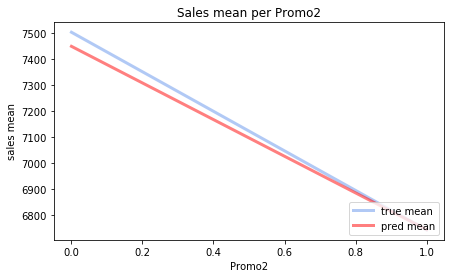

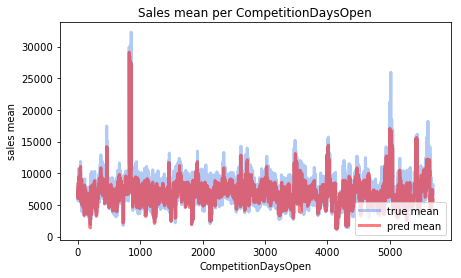

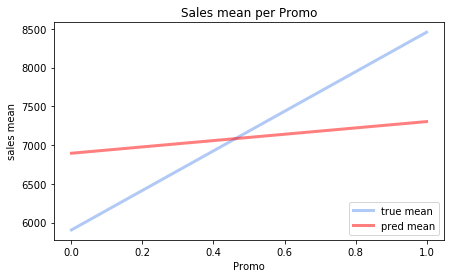

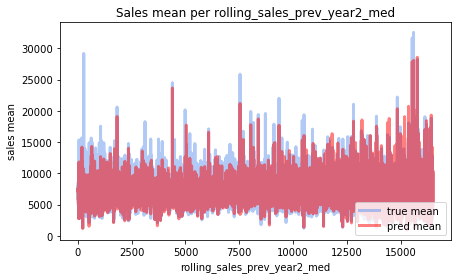

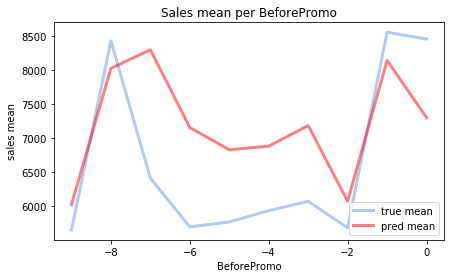

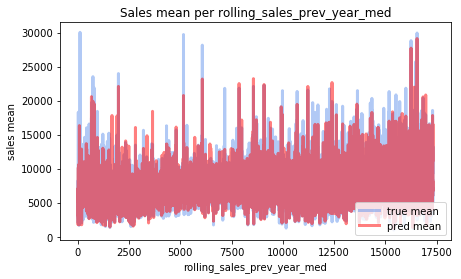

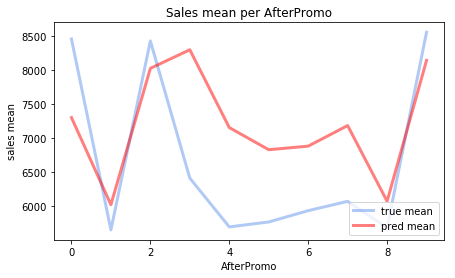

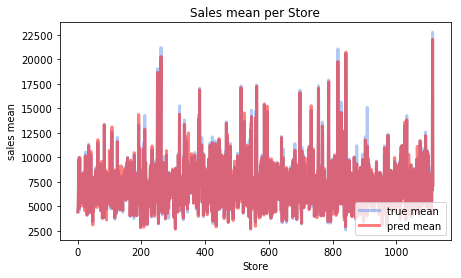

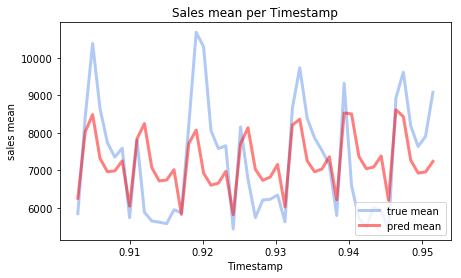

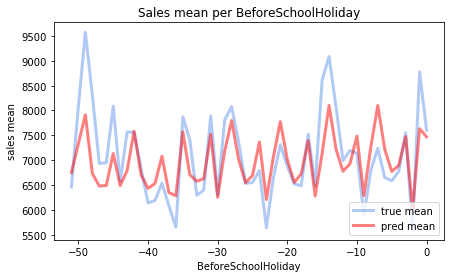

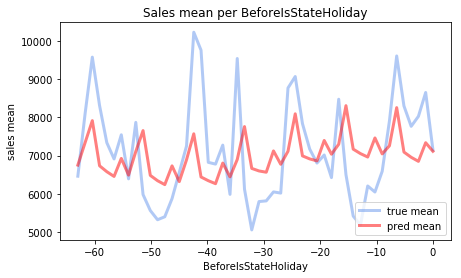

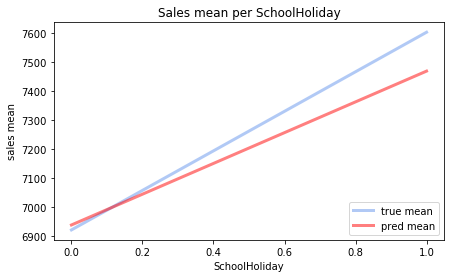

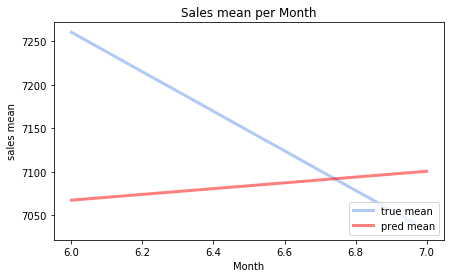

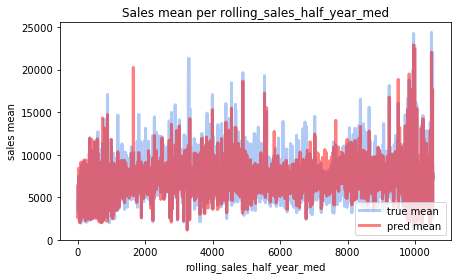

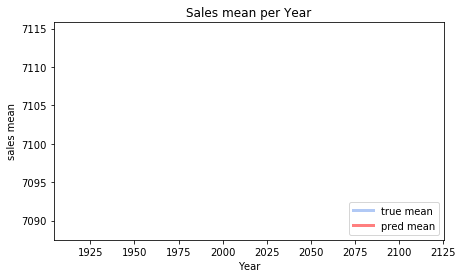

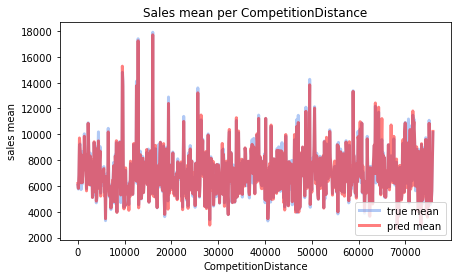

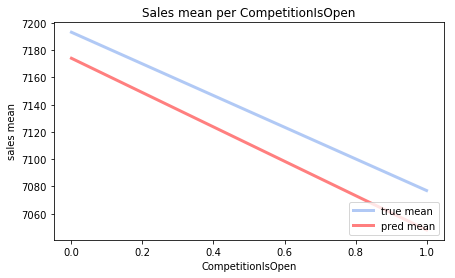

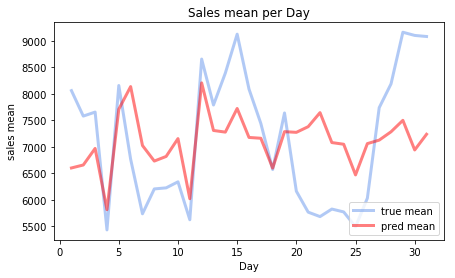

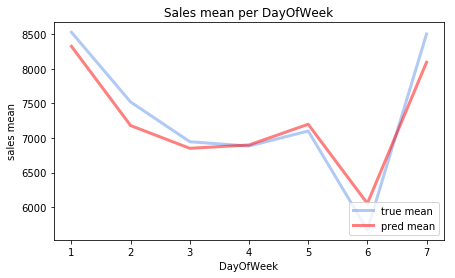

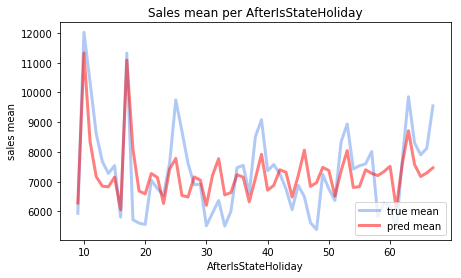

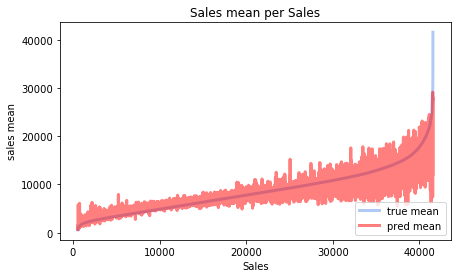

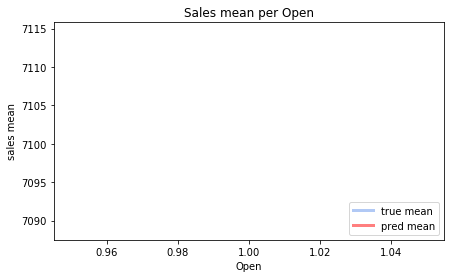

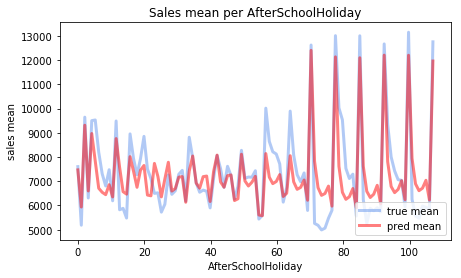

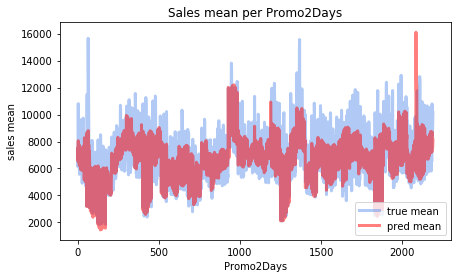

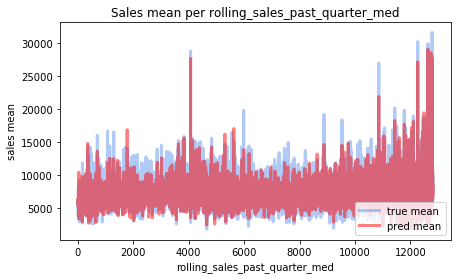

In [29]:
df_plt = data_test.sort_values(['Date','Store']).reset_index(drop=True).join(df_results.sort_values(['ds','Store']).reset_index(drop=True)[['yhat','yhat_lower','yhat_upper']])
df_plt['y_pred'] = df_plt['yhat']
df_plt['y_true'] = df_plt['Sales']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

display_cols = data_test.select_dtypes(include=numerics).columns
display_cols =  list(set( list(display_cols)))

for col in display_cols:
    compare_result_plot(df_plt, col)